In [1]:

import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

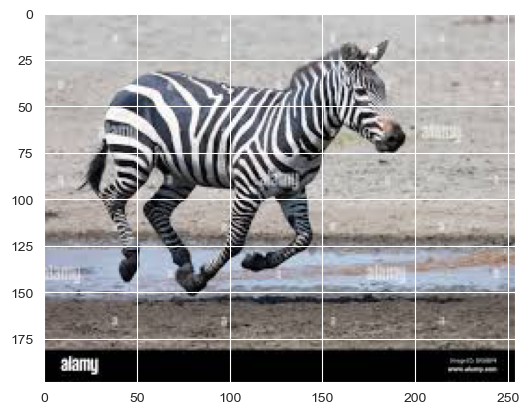

In [2]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

basedir = 'C:/Users/olabr/Downloads/aminals dataset'

%matplotlib inline
pil_im = Image.open(basedir + '/Test/Zebra/Zebra-Test (7).jpeg', 'r')

imshow(np.asarray(pil_im))

In [3]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = basedir + '/Train'
validation_data_dir = basedir + '/Valid'
test_data_dir = basedir + '/Test'
image_size = (275, 183)
batch_size = 64

In [4]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=64)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 20000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 1907 files belonging to 10 classes.


# **Image Augmentation**

In [5]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        rotation_range=15,
#        zoom_range=0.1
#)

#validation_datagen = ImageDataGenerator(
#        rescale=1./255
#)


#train_ds_augmentation = train_datagen.flow_from_directory(
#    train_data_dir,
#    #validation_split=0.2,
#    #subset="training",
#    #seed=1337,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)

#validation_ds_augmentation = validation_datagen.flow_from_directory(
#    validation_data_dir,
#    #validation_split=0.2,
#    #subset="validation",
#    #seed=1337,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)



# **The Model**

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow import keras

# MODEL --------------------------------------------------

def build_model(denseVal):
    base_model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                       input_shape=(275, 183, 3),
                       include_top=False
                       )

    base_model.trainable = False

    inputs = keras.Input(shape=(275, 183, 3))

    x = keras.applications.mobilenet.preprocess_input(inputs) # esto normaliza entre -1 y 1

    x = base_model(x, training=False)

    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(units=denseVal, activation='relu', kernel_initializer='he_normal')(x)
    x = keras.layers.Dropout(0.25)(x)

    outputs = keras.layers.Dense(10, activation='softmax')(x)


    model = keras.Model(inputs, outputs)

    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                  optimizer=tensorflow.keras.optimizers.Adam(1e-3),
                  metrics=['accuracy'])

    return model



def train_model(hp):
    return build_model(hp.Int("units", min_value=32, max_value=2048, step=32))



In [7]:
model = build_model(1600);

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 275, 183, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 275, 183, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 275, 183, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 8, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
import keras_tuner

tuner = keras_tuner.Hyperband (
    hypermodel=train_model,
    objective="val_accuracy",
    directory="tuner"
)

tuner.search_space_summary()

tuner.search(train_ds, epochs=2, validation_data=(validation_ds))

model = tuner.get_best_models()[0]
model.summary()

In [8]:
# TRAINING --------------------------------------------------

from tensorflow.keras.callbacks import EarlyStopping

epochs = 10

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)

Epoch 1/10
313/313 [==============================] - 70s 190ms/step - loss: 0.8823 - accuracy: 0.7083 - val_loss: 0.6424 - val_accuracy: 0.7930
Epoch 2/10
313/313 [==============================] - 52s 164ms/step - loss: 0.5446 - accuracy: 0.8263 - val_loss: 0.6305 - val_accuracy: 0.7950
Epoch 3/10
313/313 [==============================] - 52s 166ms/step - loss: 0.4818 - accuracy: 0.8439 - val_loss: 0.5391 - val_accuracy: 0.8140
Epoch 4/10
313/313 [==============================] - 53s 168ms/step - loss: 0.4429 - accuracy: 0.8579 - val_loss: 0.5310 - val_accuracy: 0.8300
Epoch 5/10
313/313 [==============================] - 54s 170ms/step - loss: 0.4024 - accuracy: 0.8699 - val_loss: 0.5711 - val_accuracy: 0.8140
Epoch 6/10
313/313 [==============================] - 53s 169ms/step - loss: 0.3775 - accuracy: 0.8769 - val_loss: 0.4661 - val_accuracy: 0.8530
Epoch 7/10
313/313 [==============================] - 52s 166ms/step - loss: 0.3505 - accuracy: 0.8868 - val_loss: 0.4736 - val_ac

In [9]:
# SAVING --------------------------------------------------

model.save("models/vgg_one_layer_dropout_v1.h5")

#  **Evaluación de resultados**

2/2 [==============================] - 1s 940ms/step
              precision    recall  f1-score   support

           0     0.8704    0.9400    0.9038       100
           1     0.6765    0.9200    0.7797       100
           2     0.8265    0.8100    0.8182       100
           3     0.8636    0.9500    0.9048       100
           4     0.8416    0.8500    0.8458       100
           5     0.9518    0.7900    0.8634       100
           6     0.8831    0.6800    0.7684       100
           7     0.9677    0.9000    0.9326       100
           8     0.7881    0.9300    0.8532       100
           9     0.9868    0.7500    0.8523       100

    accuracy                         0.8520      1000
   macro avg     0.8656    0.8520    0.8522      1000
weighted avg     0.8656    0.8520    0.8522      1000



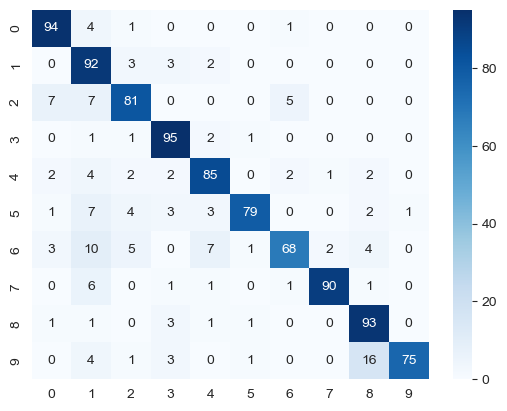

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

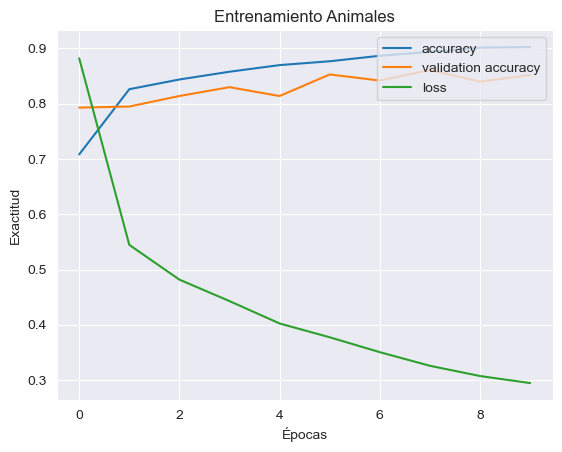

In [11]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Animales')


plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(183, 275, 3)
1/1 [==============================] - 1s 1s/step
El vector de salida obtenido:  [[5.0947187e-05 6.7415640e-05 9.9486542e-06 8.9297755e-05 1.4405701e-05
  1.1275548e-05 8.7703469e-05 8.0417696e-05 1.4365382e-02 9.8522317e-01]]
1/1 [==============================] - 0s 23ms/step
La etiqueta de salida predicha es  9
1/1 [==============================] - 0s 23ms/step
Ahora dicho con texto: La etiqueta de salida predicha es  Zebra


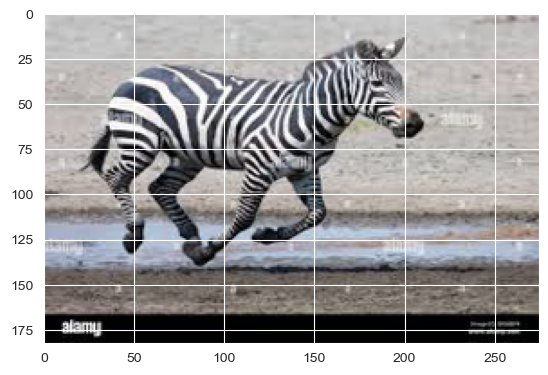

In [14]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Monkey', 'Panda', 'Tiger', 'Zebra']
%matplotlib inline

pil_im = Image.open(basedir + '/Test/Zebra/Zebra-Test (7).jpeg', 'r')
im = np.asarray(pil_im.resize((275, 183)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3 (256x256x3)

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,275, 183,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






In [15]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Monkey', 'Panda', 'Tiger', 'Zebra']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL
2/2 [==============================] - 0s 302ms/step
Elephant -> Elephant
Tiger -> Tiger
Tiger -> Tiger
Elephant -> Elephant
Dog -> Cat ✘
Monkey -> Monkey
Cat -> Cat
Panda -> Panda
Elephant -> Elephant
Tiger -> Tiger
Hippo -> Hippo
Monkey -> Monkey
Cow -> Cow
Cow -> Cow
Zebra -> Zebra
Cow -> Cow
Panda -> Panda
Cat -> Cat
Gorilla -> Gorilla
Tiger -> Tiger
Tiger -> Tiger
Monkey -> Monkey
Elephant -> Elephant
Cow -> Cow
Cow -> Cow
Cat -> Cat
Panda -> Panda
Panda -> Panda
Elephant -> Tiger ✘
Tiger -> Tiger
Panda -> Panda
Zebra -> Zebra
Elephant -> Elephant
Tiger -> Tiger
Zebra -> Zebra
Elephant -> Elephant
Cow -> Cat ✘
Cat -> Cat
Zebra -> Zebra
Cat -> Cat
Cat -> Cat
Elephant -> Elephant
Panda -> Panda
Elephant -> Elephant
Cat -> Cat
Monkey -> Dog ✘
Elephant -> Elephant
Panda -> Panda
Cat -> Cat
Tiger -> Tiger
Panda -> Panda
Cat -> Cat
Tiger -> Tiger
Monkey -> Monkey
Zebra -> Zebra
Zebra -> Zebra
Monkey -> Monkey
Tiger -> Tiger
Panda -> Panda
Monkey -> Mon